In [1]:
import numpy as np
import torch

/home/pimienta/Documents/repos/coding/vocalpy/vak-vocalpy/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd /home/pimienta/Documents/repos/coding/vocalpy/vak-vocalpy/

/home/pimienta/Documents/repos/coding/vocalpy/vak-vocalpy


In [3]:
def convert_distance_to_probability(distances, a=1.0, b=1.0):
    """Convert distances to probability.

    Computes equation (2.6) of Sainburg McInnes Gentner 2021,
    :math:`q_{ij} = (1 + a \abs{z_i - z_j}^{2b} )^{-1}`.

    The function uses torch.log1p to avoid floating point error:
    ``-torch.log1p(a * distances ** (2 * b))``.
    See https://en.wikipedia.org/wiki/Natural_logarithm#lnp1
    """
    #return 1.0 / (1.0 + a * distances ** (2 * b))
    return -torch.log1p(a * distances ** (2 * b))

In [4]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    """Computes cross entropy as used for UMAP cost function"""
    # cross entropy
    attraction_term = -probabilities_graph * torch.nn.functional.logsigmoid(
        probabilities_distance
    )
    repulsion_term = (
        -(1.0 - probabilities_graph) * (torch.nn.functional.logsigmoid(probabilities_distance) - probabilities_distance) * repulsion_strength
    )

    # balance the expected losses between attraction and repulsion
    CE = attraction_term + repulsion_term
    return attraction_term, repulsion_term, CE

In [5]:
def umap_loss(embedding_to, embedding_from, a, b, batch_size, negative_sample_rate=5):
    """UMAP loss function

    Converts distances to probabilities,
    and then computes cross entropy.
    """
    # get negative samples by randomly shuffling the batch
    embedding_neg_to = embedding_to.repeat(negative_sample_rate, 1)
    repeat_neg = embedding_from.repeat(negative_sample_rate, 1)
    embedding_neg_from = repeat_neg[torch.randperm(repeat_neg.shape[0])]
    distance_embedding = torch.cat((
        (embedding_to - embedding_from).norm(dim=1),
        (embedding_neg_to - embedding_neg_from).norm(dim=1)
    # ``to`` method in next line to avoid error `Expected all tensors to be on the same device`
    ), dim=0).to(embedding_to.device)

    # convert probabilities to distances
    probabilities_distance = convert_distance_to_probability(
        distance_embedding, a, b
    )
    # set true probabilities based on negative sampling
    probabilities_graph = torch.cat(
        (torch.ones(batch_size), torch.zeros(batch_size * negative_sample_rate)), dim=0,
    # ``to`` method in next line to avoid error `Expected all tensors to be on the same device`
    ).to(embedding_to.device)

    # compute cross entropy
    (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
        probabilities_graph,
        probabilities_distance,
    )
    loss = torch.mean(ce_loss)
    return loss

In [6]:
from pynndescent import NNDescent
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set


def get_umap_graph(X, n_neighbors: int = 10, metric: str= "cosine", random_state: int | None = None, max_candidates=60, verbose=True):
    random_state = check_random_state(None) if random_state == None else random_state

    # number of trees in random projection forest
    n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))

    # max number of nearest neighbor iters to perform
    n_iters = max(5, int(round(np.log2(X.shape[0]))))
    # distance metric

    # get nearest neighbors
    nnd = NNDescent(
        X.reshape((len(X), np.product(np.shape(X)[1:]))),
        n_neighbors=n_neighbors,
        metric=metric,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=max_candidates,
        verbose=verbose
    )

    # get indices and distances
    knn_indices, knn_dists = nnd.neighbor_graph

    # build fuzzy_simplicial_set
    umap_graph, sigmas, rhos = fuzzy_simplicial_set(
        X=X,
        n_neighbors=n_neighbors,
        metric=metric,
        random_state=random_state,
        knn_indices=knn_indices,
        knn_dists=knn_dists,
    )

    return umap_graph

/home/pimienta/Documents/repos/coding/vocalpy/vak-vocalpy/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pimienta/Documents/repos/coding/vocalpy/vak-vocalpy/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pimien

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# graph is scipy.sparse.csc_matrix? Guessing from .tocoo method call


def get_graph_elements(graph, n_epochs):
    """Get graph elements for UMAP Dataset"""

    graph = graph.tocoo()

    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()

    # number of vertices in dataset
    n_vertices = graph.shape[1]

    # get the number of epochs based on the size of the dataset
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200

    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()

    # get epochs per sample based upon edge probability
    epochs_per_sample = n_epochs * graph.data

    head = graph.row
    tail = graph.col
    weight = graph.data

    return graph, epochs_per_sample, head, tail, weight, n_vertices


import pathlib

import pandas as pd

import vak.datasets


class UMAPDataset(Dataset):
    def __init__(self, data, graph, n_epochs=200, transform=None):
        graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(graph, n_epochs)

        self.edges_to_exp, self.edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
        np.repeat(tail, epochs_per_sample.astype("int")),
    )
        shuffle_mask = np.random.permutation(np.arange(len(self.edges_to_exp)))
        self.edges_to_exp = self.edges_to_exp[shuffle_mask].astype(np.int64)
        self.edges_from_exp = self.edges_from_exp[shuffle_mask].astype(np.int64)
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return int(self.data.shape[0])
    
    def __getitem__(self, index):
        edges_to_exp = self.data[self.edges_to_exp[index]]
        edges_from_exp = self.data[self.edges_from_exp[index]]
        if self.transform:
            edges_to_exp = self.transform(edges_to_exp)
            edges_from_exp = self.transform(edges_from_exp)
        return (edges_to_exp, edges_from_exp)

    @classmethod
    def from_dataset_path(cls, 
                          dataset_path,
                          split, 
                          n_neighbors=10,
                          metric='Euclidean',
                          random_state=None,
                          n_epochs=200,
                          transform=None):
        dataset_path = pathlib.Path(dataset_path)
        metadata = vak.datasets.dimensionality_reduction.Metadata.from_dataset_path(dataset_path)

        dataset_csv_path = dataset_path / metadata.dataset_csv_filename
        dataset_df = pd.read_csv(dataset_csv_path)
        split_df = dataset_df[dataset_df.split == split]

        split_path = dataset_path / split

        data = np.stack(
            [
                np.load(dataset_path / spect_path) for spect_path in split_df.spect_path.values
            ]
        )
        graph = get_umap_graph(data, n_neighbors=n_neighbors, metric=metric, random_state=random_state)

        return cls(
            data,
            graph,
            n_epochs,
            transform=transform,
        )

In [8]:
import torch
import torch.nn as nn


class ConvEncoder(nn.Module):
    def __init__(self,
                 input_shape,
                 n_components=2):
        super().__init__()

        self.num_input_channels = input_shape[-3]
        num_freqbins = input_shape[-2]

                     
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1,
            ),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1,
            ),
            nn.Flatten()
        )
        mock_input = torch.rand((1, *input_shape))
        mock_conv_out = self.conv(mock_input)
        in_features = mock_conv_out.shape[-1]

        self.encoder = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, n_components)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.encoder(x)
        return x

In [9]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss

from umap.umap_ import find_ab_params


class ParametricUMAPModel(pl.LightningModule):
    def __init__(
        self,
        lr: float,
        encoder: nn.Module,
        decoder: nn.Module | None = None,
        beta: float = 1.0,
        min_dist: float = 0.1,
    ):DatamoduleDatamodule
        super().__init__()
        self.lr = lr
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta # weight for reconstruction loss
        self._a, self._b = find_ab_params(1.0, min_dist)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        (edges_to_exp, edges_from_exp) = batch
        embedding_to, embedding_from = self.encoder(edges_to_exp), self.encoder(edges_from_exp)
        encoder_loss = umap_loss(embedding_to, embedding_from, self._a, self._b, edges_to_exp.shape[0], negative_sample_rate=5)
        self.log("umap_loss", encoder_loss)

        if self.decoder != None:
            recon = self.decoder(embedding_to)
            recon_loss = mse_loss(recon, edges_to_exp)
            self.log("recon_loss", recon_loss)
            return encoder_loss + self.beta * recon_loss
        else:
            return encoder_loss

In [11]:
class ParametricUMAP:
    def __init__(
        self,
        encoder: torch.nn.Module,
        decoder: torch.nn.Module | None = None,
        n_neighbors: int = 10,
        min_dist: float = 0.1,
        metric: str = "euclidean",
        lr: float = 1e-3,
        num_epochs: int = 30,
        batch_size: int = 64,
        num_workers: int = 16,
        random_state: int | None = None,
    ):
        self.encoder = encoder
        self.decoder = decoder
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.metric = metric

        self.lr = lr
        self.num_epochs = num_epochs

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.random_state = random_state

        self.model = ParametricUMAPModel(self.lr, self.encoder, min_dist=self.min_dist)

    def fit(self, dataset_path, accelerator='gpu', devices=1, transform=None):
        trainer = pl.Trainer(accelerator=accelerator, devices=devices, max_epochs=self.num_epochs)
        dataset = UMAPDataset.from_dataset_path(dataset_path, 'train', self.n_neighbors, self.metric, 
                                                self.random_state, self.num_epochs, transform)
        trainer.fit(
            model=self.model,
            datamodule=Datamodule(dataset, self.batch_size, self.num_workers)
        )

    @torch.no_grad()
    def transform(self, X):
        self.embedding_ = self.model.encoder(X).detach().cpu().numpy()
        return self.embedding_

    @torch.no_grad()
    def inverse_transform(self, Z):
        return self.model.decoder(Z).detach().cpu().numpy()

In [12]:
# import torchvision
# from torchvision.transforms import transforms

# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
# train_tensor = torch.stack([example[0] for example in train_dataset])[:, 0][:, None, ...]
# labels = [str(example[1]) for example in train_dataset]
# X = train_tensor

In [12]:
import torchvision
import vak.transforms

transform = torchvision.transforms.Compose(
        [
            vak.transforms.ToFloatTensor(),
            vak.transforms.AddChannel(),
            torchvision.transforms.Resize((256, 128))
        ]
)

In [13]:
pumap = ParametricUMAP(ConvEncoder((1, 256, 128), 2), lr=1e-3, num_epochs=10, num_workers=8)
pumap.fit(dataset_path='tests/data_for_tests/generated/prep/train/audio_cbin_annot_notmat/pumap/032312-vak-dimensionality-reduction-dataset-generated-230712_065612',
          transform=transform)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sun Jul 16 07:59:30 2023 Building RP forest with 6 trees
Sun Jul 16 07:59:34 2023 NN descent for 9 iterations
	 1  /  9
	 2  /  9
	 3  /  9
	Stopping threshold met -- exiting after 3 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | encoder | ConvEncoder | 134 M 
----------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
538.226   Total estimated model params size (MB)
/home/pimienta/Documents/repos/coding/vocalpy/vak-vocalpy/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.52it/s, loss=0.193, v_num=3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s, loss=0.193, v_num=3]


In [14]:
dataset_path = pathlib.Path('tests/data_for_tests/generated/prep/train/audio_cbin_annot_notmat/pumap/032312-vak-dimensionality-reduction-dataset-generated-230712_065612')
metadata = vak.datasets.dimensionality_reduction.Metadata.from_dataset_path(dataset_path)

dataset_csv_path = dataset_path / metadata.dataset_csv_filename
dataset_df = pd.read_csv(dataset_csv_path)
split_df = dataset_df[dataset_df.split == 'train']

split_path = dataset_path / 'val'

data = torch.stack(
    [
        transform(np.load(dataset_path / spect_path)) for spect_path in split_df.spect_path.values
    ]
)

In [15]:
out = pumap.transform(data)

In [16]:
labels = split_df.label.values

In [17]:
import seaborn as sns

In [18]:
palette = dict(
    zip(np.unique(labels), sns.color_palette('tab10', len(np.unique(labels))))
)

In [19]:
records = []
for x, y, lbl in zip(out[:,0], out[:,1], split_df.label.values):
    records.append(
        {'x': x, 'y': y, 'Label': lbl}
    )
plot_df = pd.DataFrame.from_records(records)

In [20]:
colors = [palette[label] for label in labels]

In [21]:
sns.set()

In [22]:
import matplotlib.pyplot as plt

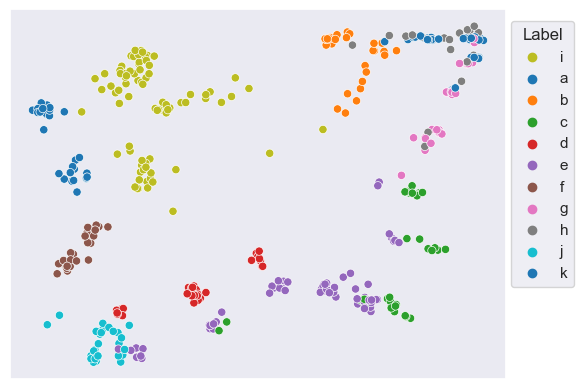

In [23]:
g = sns.scatterplot(
    plot_df,
    x='x',
    y='y',
    palette=palette,
    hue='Label'
)

sns.move_legend(g, loc=[1.01, 0.25])
g.axes.set_xlabel('')
g.axes.set_ylabel('')
g.axes.set_xticks([])
g.axes.set_yticks([])

plt.savefig('../scipy_proceedings/papers/david_nicholson/parametric-umap.png', 
            bbox_inches='tight')

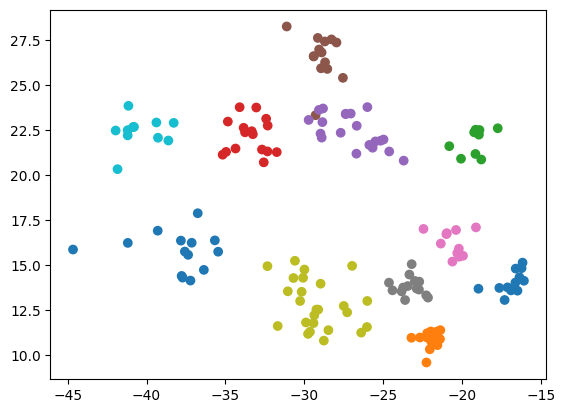

In [96]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(out[:, 0], out[:, 1], c=colors)
